## Python statistics essential training - 03_08_email

Standard imports

In [1]:
import numpy as np
import scipy.stats
import pandas as pd

In [2]:
import matplotlib
import matplotlib.pyplot as pp

import pandas.plotting

from IPython import display
from ipywidgets import interact, widgets

%matplotlib inline

In [3]:
import re
import mailbox
import csv

### How I converted my mailbox.

In [4]:
mbox = mailbox.mbox('Sent.mbox')

The resulting object is array-like, with one entry per message. Each entry is dictionary like, with keys corresponding to metadata and data for each message.

In [5]:
mbox[0].keys()

['X-GM-THRID',
 'X-Gmail-Labels',
 'MIME-Version',
 'Date',
 'References',
 'In-Reply-To',
 'Message-ID',
 'Subject',
 'From',
 'To',
 'Content-Type']

The easiest way to get these data into Pandas is to build a CSV file from them. We use the module `csv` to write out the CSV file as we loop over the mailbox object. We save only subject, from, to, and date, and we write a simple header at the top with the names of columns.

In [6]:
with open('mbox.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['subject','from','to','date'])
    
    for message in mbox:
        writer.writerow([message['subject'], message['from'], message['to'], message['date']])

All done! Thanks to Justin Ellis for inspiration with https://jellis18.github.io/post/2018-01-17-mail-analysis.

## Moving on!

In [7]:
messages = pd.read_csv('mbox.csv')

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2723 entries, 0 to 2722
Data columns (total 4 columns):
subject    2695 non-null object
from       2723 non-null object
to         2720 non-null object
date       2723 non-null object
dtypes: object(4)
memory usage: 85.2+ KB


In [10]:
messages.head()

,subject,from,to,date
0,Re: Reference # 190732569,Alireza Talebizadeh <alireza.talebizadeh@gmail...,VW Experience <VWExperience@vw.com>,"Thu, 7 Nov 2019 15:20:35 -0600"
1,Reference # 190732569,VW Experience <VWExperience@vw.com>,"""alireza.talebizadeh@gmail.com"" <alireza.taleb...","Fri, 1 Nov 2019 21:28:46 +0000"
2,Re: Amazon Returns Policy Notice,Alireza Talebizadeh <alireza.talebizadeh@gmail...,"""ofm@amazon.com"" <ofm@amazon.com>","Thu, 21 Nov 2019 12:07:42 -0600"
3,Amazon Returns Policy Notice,"""ofm@amazon.com"" <ofm@amazon.com>",alireza.talebizadeh@gmail.com,"Thu, 21 Nov 2019 05:32:29 +0000"
4,Resume Programming,Alireza Talebizadeh <alireza.talebizadeh@gmail...,Alireza Talebizadeh <atalebizadeh@icloud.com>,"Mon, 18 Feb 2019 00:11:37 -0600"


In [12]:
messages['from'][0]

'Alireza Talebizadeh <alireza.talebizadeh@gmail.com>'

In [14]:
re.search('<(.+)>', messages['from'][0])

<re.Match object; span=(20, 51), match='<alireza.talebizadeh@gmail.com>'>

In [15]:
re.search('<(.+)>', messages['from'][0]).group(0)

'<alireza.talebizadeh@gmail.com>'

In [16]:
re.search('<(.+)>', messages['from'][0]).group(1)

'alireza.talebizadeh@gmail.com'

In [18]:
re.search('<(.+)>', 'alireza.talebizadeh@gmail.com').group(1)

AttributeError: 'NoneType' object has no attribute 'group'

In [20]:
def clean_address(raw):
    match = re.search('<(.+)>', raw)
    
    if match is None:
        return raw
    else:
        return match.group(1)

In [21]:
clean_address(messages['from'][0])

'alireza.talebizadeh@gmail.com'

In [22]:
messages['from'] = messages['from'].apply(clean_address)

In [25]:
messages['to'] = messages['to'].apply(clean_address)

TypeError: expected string or bytes-like object

In [26]:
messages['to'].isnull().sum()

3

In [27]:
%debug

> c:\users\atale\appdata\local\continuum\anaconda3\lib\re.py(183)search()
    181     """Scan through string looking for a match to the pattern, returning
    182     a Match object, or None if no match was found."""
--> 183     return _compile(pattern, flags).search(string)
    184 
    185 def sub(pattern, repl, string, count=0, flags=0):

ipdb> up
> <ipython-input-20-934bd7fa4389>(2)clean_address()
      1 def clean_address(raw):
----> 2     match = re.search('<(.+)>', raw)
      3 
      4     if match is None:
      5         return raw

ipdb> print(raw)
nan
ipdb> quit


In [30]:
messages['to'] = messages['to'].dropna().apply(clean_address)

In [33]:
messages['from'] = messages['from'].dropna().apply(clean_address)

In [34]:
messages.head()

,subject,from,to,date
0,Re: Reference # 190732569,alireza.talebizadeh@gmail.com,VWExperience@vw.com,"Thu, 7 Nov 2019 15:20:35 -0600"
1,Reference # 190732569,VWExperience@vw.com,alireza.talebizadeh@gmail.com,"Fri, 1 Nov 2019 21:28:46 +0000"
2,Re: Amazon Returns Policy Notice,alireza.talebizadeh@gmail.com,ofm@amazon.com,"Thu, 21 Nov 2019 12:07:42 -0600"
3,Amazon Returns Policy Notice,ofm@amazon.com,alireza.talebizadeh@gmail.com,"Thu, 21 Nov 2019 05:32:29 +0000"
4,Resume Programming,alireza.talebizadeh@gmail.com,atalebizadeh@icloud.com,"Mon, 18 Feb 2019 00:11:37 -0600"


In [35]:
messages['date'][0]

'Thu, 7 Nov 2019 15:20:35 -0600'

In [39]:
pd.to_datetime(messages['date'][0]).tz_convert('America/Chicago')

Timestamp('2019-11-07 15:20:35-0600', tz='America/Chicago')

In [40]:
messages['date'] = messages['date'].apply(lambda s: pd.to_datetime(s).tz_convert('America/Chicago'))

In [41]:
messages['date']

0      2019-11-07 15:20:35-06:00
1      2019-11-01 16:28:46-05:00
2      2019-11-21 12:07:42-06:00
3      2019-11-20 23:32:29-06:00
4      2019-02-18 00:11:37-06:00
5      2019-08-07 07:28:12-05:00
6      2019-08-06 15:24:00-05:00
7      2019-08-06 12:38:54-05:00
8      2019-08-06 12:36:00-05:00
9      2019-08-05 11:30:25-05:00
10     2019-03-12 11:48:33-05:00
11     2019-03-12 10:38:18-05:00
12     2019-03-12 10:24:29-05:00
13     2019-03-12 10:19:13-05:00
14     2019-03-12 10:07:14-05:00
15     2019-11-06 20:31:40-06:00
16     2019-11-06 16:00:00-06:00
17     2019-11-06 07:35:23-06:00
18     2019-11-06 07:32:39-06:00
19     2019-11-05 15:47:53-06:00
20     2019-10-31 13:31:39-05:00
21     2019-10-31 13:10:35-05:00
22     2019-10-31 13:07:04-05:00
23     2019-10-31 13:05:13-05:00
24     2019-10-31 13:02:18-05:00
25     2019-10-31 13:00:04-05:00
26     2019-10-31 10:23:04-05:00
27     2017-12-29 21:34:08-06:00
28     2017-12-29 21:14:51-06:00
29     2017-12-29 18:28:40-06:00
          

In [42]:
messages['date'].min(), messages['date'].max()

(Timestamp('2012-02-12 21:58:15-0600', tz='America/Chicago'),
 Timestamp('2019-12-20 23:03:14-0600', tz='America/Chicago'))

### Let's break the date object a part

In [43]:
messages['date'].dt.weekday_name.head()

0     Thursday
1       Friday
2     Thursday
3    Wednesday
4       Monday
Name: date, dtype: object

In [47]:
messages['dayofweek'] = pd.Categorical(messages['date'].dt.weekday_name,
                                      ordered=True, categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [48]:
messages['dayofweek']

0        Thursday
1          Friday
2        Thursday
3       Wednesday
4          Monday
5       Wednesday
6         Tuesday
7         Tuesday
8         Tuesday
9          Monday
10        Tuesday
11        Tuesday
12        Tuesday
13        Tuesday
14        Tuesday
15      Wednesday
16      Wednesday
17      Wednesday
18      Wednesday
19        Tuesday
20       Thursday
21       Thursday
22       Thursday
23       Thursday
24       Thursday
25       Thursday
26       Thursday
27         Friday
28         Friday
29         Friday
          ...    
2693      Tuesday
2694       Friday
2695     Thursday
2696     Thursday
2697     Thursday
2698      Tuesday
2699     Saturday
2700     Saturday
2701      Tuesday
2702       Sunday
2703     Thursday
2704       Monday
2705       Monday
2706       Monday
2707       Monday
2708       Monday
2709       Monday
2710       Sunday
2711       Sunday
2712       Sunday
2713       Sunday
2714       Sunday
2715    Wednesday
2716    Wednesday
2717      

In [53]:
messages['timeofday'] = messages['date'].dt.hour + messages['date'].dt.minute / 60

In [54]:
messages['timeofday']

0       15.333333
1       16.466667
2       12.116667
3       23.533333
4        0.183333
5        7.466667
6       15.400000
7       12.633333
8       12.600000
9       11.500000
10      11.800000
11      10.633333
12      10.400000
13      10.316667
14      10.116667
15      20.516667
16      16.000000
17       7.583333
18       7.533333
19      15.783333
20      13.516667
21      13.166667
22      13.116667
23      13.083333
24      13.033333
25      13.000000
26      10.383333
27      21.566667
28      21.233333
29      18.466667
          ...    
2693    10.050000
2694     8.033333
2695     8.183333
2696     8.166667
2697     8.116667
2698    12.516667
2699     8.250000
2700     3.666667
2701    15.016667
2702    12.933333
2703     9.433333
2704    20.200000
2705    19.583333
2706    16.750000
2707    15.550000
2708    13.850000
2709    12.000000
2710    20.050000
2711    11.416667
2712    11.266667
2713    11.116667
2714    10.116667
2715    11.566667
2716     1.066667
2717    18

In [74]:
messages['nyear'] = messages['date'].dt.year + messages['date'].dt.dayofyear / 365.25 + messages['timeofday'] / 24 / 365.25

In [75]:
messages['nyear']

0       2019.853221
1       2019.836923
2       2019.891184
3       2019.889748
4       2019.134176
5       2019.600441
6       2019.598608
7       2019.598293
8       2019.598289
9       2019.595426
10      2019.195734
11      2019.195600
12      2019.195574
13      2019.195564
14      2019.195541
15      2019.851074
16      2019.850559
17      2019.849599
18      2019.849593
19      2019.847796
20      2019.833849
21      2019.833809
22      2019.833803
23      2019.833799
24      2019.833793
25      2019.833790
26      2019.833491
27      2017.996300
28      2017.996262
29      2017.995946
           ...     
2693    2016.053166
2694    2016.041984
2695    2016.039263
2696    2016.039262
2697    2016.039256
2698    2016.034282
2699    2012.882529
2700    2012.882006
2701    2015.976388
2702    2017.406677
2703    2017.148920
2704    2017.141935
2705    2017.141864
2706    2017.141541
2707    2017.141404
2708    2017.141210
2709    2017.140999
2710    2017.139180
2711    2017.138195


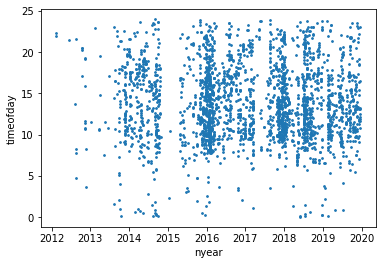

In [78]:
messages.plot.scatter('nyear', 'timeofday', s=3)

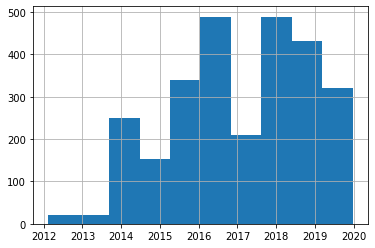

In [79]:
messages['nyear'].hist()

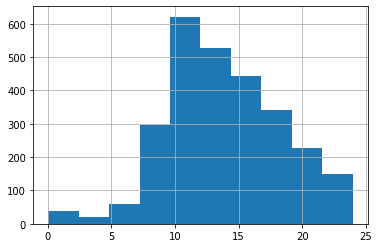

In [80]:
messages['timeofday'].hist()

In [81]:
messages['dayofweek'].value_counts()

Monday       569
Tuesday      519
Wednesday    461
Thursday     445
Friday       368
Saturday     189
Sunday       172
Name: dayofweek, dtype: int64

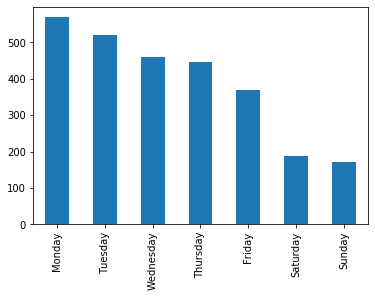

In [82]:
counts = messages['dayofweek'].value_counts(sort=False)
counts.plot(kind='bar')